##Data Source

The dataset used for this assignment was provided by Julian McAuley and was found using the links suggested in the assginment (http://jmcauley.ucsd.edu/cse255/data/beer/Ratebeer.txt.gz). This data was collected as a part of the following studies (https://snap.stanford.edu/data/web-RateBeer.html):

[1] J. McAuley, J. Leskovec, and D. Jurafsky. Learning attitudes and attributes from multi-aspect reviews. ICDM, 2012.

[2] J. McAuley and J. Leskovec. From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews. WWW, 2013.

This dataset includes 2924164 user-provided reviews from the RateBeer website from the period of time 04/12/2000 to 01/13/2012. For the purposes of our analysis, we filtered the dataset down to a period of time +/- 1 year from the feature change date of 05/01/2009 (so 5/1/2008 - 5/1/2010). This narrows our dataset to be 801276 reviews from 9453 users. 

Note: Throughout our code, we assume that the file 'data/reduced_data.txt' has been generated. This can be generated using the ParseBeerData notebook.

##User Level Drill-Down Analysis

In addition to looking at site-level impact, we also hypothesized that the website changes may have altered the way that individual users engaged with and contributed to the overall community. This portion of the analysis looks at trends in select features and identifies how a user's contribution level before the remodel correlated with observed contribution changes after. 

We conclude this section by building a classification model to predict (based on a user's contributions before the "split") how the number of reviews contributed by the user change after the "split" [frome hereon referred to as "pre-split" and "post-split"].We test several different linear classifiers and evaluate how predictive the features identified really are. 

For the purposes of this analysis, we focused on the following user feature variables:
* Number of Reviews Posted - Users more commited to the community will post more reviews
* Review Diversity - Users who are more engaged will post more and more diverse information
    * Types of Beers - Count
    * Rating Scores - Number of Different, Average
    * Review Length - Number of Different, Average

###Data Parsing

In [1]:
# import statements
%matplotlib inline
import json
import unicodedata
import random
import calendar
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby

In [2]:
"""
Helper to return unicode string as ascii with special characters removed.
"""
def clean_unicode(instr):
    return unicodedata.normalize('NFKD', instr).encode('ascii', 'ignore')

"""
Helper to parse a JSON file and yield individual components
Calls clean_unicode to normalize to ascii characters
"""
def parse_json(filename, normalize=True):
    with open(filename) as f:
        for line in f:
            out = json.loads(line, encoding='latin-1')
            if normalize:
                temp = {}
                for key in out:
                    try:
                        key = clean_unicode(key)
                    except:
                        key = key
                    try:
                        temp[key] = clean_unicode(out[key])
                    except:
                        temp[key] = out[key]
                out = temp
            yield out
    f.close()

"""
A variety of helper methods to group data structures accordingto 
"""
def groupby_key(data, key_str):
    key_map = {}
    for datum in data:
        key = datum.get(key_str)
        key_map[key] = key_map.setdefault(key, [])
        key_map[key].append(datum)
    return key_map

def groupby_key_count(data, key_str, func=None):
    key_map = {}
    for datum in data:
        key = datum.get(key_str)
        try:
            key = func(key)
        except: 
            key = key
        key_map[key] = key_map.setdefault(key, 0) + 1
    return key_map

def group_time_split(user_array, key, func=None):
    return [[groupby_key_count(time_per, key, func) for time_per in user] for user in user_array]

"""
Reservoir sampling given an iterable input and k for number of items to be sampled
"""
def reservoir_sample(iterator, k):
    iterator = iter(iterator)
    # fill the reservoir to start
    result = [next(iterator) for _ in range(k)]
    n = k
    for item in iterator:
        n += 1
        s = random.randint(0, n)
        if s < k:
            result[s] = item
    return result
"""
Calculates the average using dictionary keys as "values" and dictionary values as "counts"
"""
def avg_from_map(keymap):
    count, total, a = 0, 0, None
    for key in keymap:
        if (key):
            count += keymap[key]
            total += key * keymap[key]
    if (count):
        a = total / count
    return a

"""
average from user tuple array
"""
def avg_from_user_array_tuple(array):
    out = []
    for user in array:
        user_avg = []
        for time in user:
            count, total, a = 0, 0, None
            for item in time:
                count += item[1]
                total += item[0] * item[1]
            if count > 0: 
                a = total/count
            user_avg.append(a) 
        out.append(user_avg)
    return out

In [3]:
# Parse and read in dataset from reduced_data.txt (as produced by our parsing code)
parsed_red = parse_json('data/reduced_data.txt', normalize=True)
dset = [i for i in parsed_red]

In [4]:
# parse dataset, grouping reviews by username
users = groupby_key(dset,'user/profileName')
user_vals = users.values()
print 'number of users', len(user_vals)

# split each users' group of reviews into two buckets: before and after site changes
user_vals_split = []
split_timestamp = calendar.timegm(datetime(2009,5,1).timetuple())

for i , posts in enumerate(user_vals):
    pre = [post for post in posts if post.get('review/timeUnix') < split_timestamp]
    post = [post for post in posts if post.get('review/timeUnix') >= split_timestamp]
#     Only look at users who already contributed in the prior period
    if len(pre) > 0:
        user_vals_split.append([pre, post])

# sort reviews according to the number of reviews users contributed before 
user_vals_split = sorted(user_vals_split, key=lambda user: len(user[0]))
print 'number of users post split', len(user_vals_split)

number of users 9453
number of users post split 6203


###High-level Feature Trends
As we brainstormed features which may reflect a user's engagement level, we eventually settled on the following variables: number of reviews contributed, review diversity (types of beers being reviewed), average review rating (score), and average review length (word count). 

Specifically, we were interested in seeing how each of these variables changed "pre-split" to "post-split" based on the user's relative amount of reviews contributed "pre-split". 

In order to look at these features, we sorted the user dataset based on the number of reviews each user contributed "pre-split" and calculated a plus-minus value for each of the variables we looked at (plus-minus calculated as value_post_split - value_pre_split). We then plotted these values for the entire population and calculated mean, median, and standard deviation.

Over the course of our analysis, we noticed that high-usage users typically exhibited more extreme changes in plus-minus. For this reason, we also performed the mean/median/stdev analysis for the top 5% of users. In order to provide a control for these high-usage users, we paired the high-usage statistics with the numbers for a ramdomly sampled group of the same size from the entire dataset as well as the "long tail" of 95% other users.

In [5]:
# sample "top" 5% and "low" 95% of users
users_top = user_vals_split[int(math.floor(len(user_vals_split)*0.95)):]
users_low = user_vals_split[:int(math.floor(len(user_vals_split)*0.95))]

# sample "random" user group to be equal to the "top" group
sample_size = len(users_top)
users_sampled = reservoir_sample(user_vals_split, sample_size)

In [6]:
"""
Plot utility to plot the users's plus minus
Prints out the mean, median, and standard deviation for the plus minus 
"""
def plot_diff(user_list, func=lambda x: x, plot=True):
    user_pre = [func(user[0]) for user in user_list]
    user_post = [func(user[1]) for user in user_list]

    np_pre = np.array(user_pre)
    np_post = np.array(user_post)
    np_pm = np_post - np_pre
    print "Mean p/m: ", np.mean(np_pm)
    print "Median p/m: ", np.median(np_pm)
    print "Std Dev p/m: ", np.std(np_pm)

    ind = np.arange(len(np_pm))
    if (plot):
        fig, ax = plt.subplots()
        ax.scatter(ind, np_pm, c="grey",s=10,edgecolor='none')
#         ax.axhline(y=np.mean(np_pm),xmin=0,xmax=ind[len(ind) - 1],c="blue",linewidth=1.1,zorder=1)
#         ax.axhline(y=np.median(np_pm),xmin=0,xmax=ind[len(ind) - 1],c="red",linewidth=1.1,zorder=2)

#### Review Counts
Based on the results below, we notice that, across the board, user contribution (as measured by review count) seem to have decreased after the profile-page change (counter what we would have predicted based on the increased behavioral incentive on the profile page). This includes users who didn't contribute in the second period at all (reflecting a lack of user retention). 

We notice that, on average, high-usage users seem to have skewed the overall average review count downwards as the average "high-usage" user had a review count decrease of 76 as compared to ~3 for both the long-tail and the random sample group (which makes sense considering a finite cap in number of beers to be reviewed). We do notice that there does appear to be a fair number of "mid-usage" users who did have the number of reviews contributed increase after the change.

all user review counts
Mean p/m:  -6.36288892471
Median p/m:  -2.0
Std Dev p/m:  96.21711247

top user review counts 311
Mean p/m:  -73.2540192926
Median p/m:  -87.0
Std Dev p/m:  291.706978315

low user review counts 5892
Mean p/m:  -2.83214528174
Median p/m:  -2.0
Std Dev p/m:  70.7548392906

sampled user review counts 311
Mean p/m:  -11.7942122186
Median p/m:  -2.0
Std Dev p/m:  73.8058378642



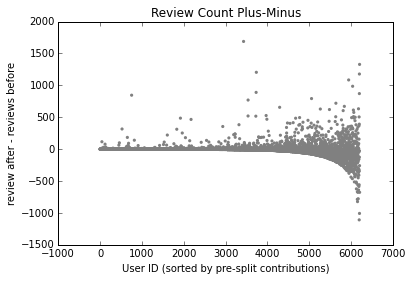

In [7]:
# review counts
# all users stats
print 'all user review counts'
plot_diff(user_vals_split, lambda x: len(x))
plt.xlabel('User ID (sorted by pre-split contributions)')
plt.ylabel('review after - reviews before')
plt.title('Review Count Plus-Minus')
print

# top users stats
print 'top user review counts', len(users_top)
plot_diff(users_top, lambda x: len(x), False)
print

# low users stats
print 'low user review counts', len(users_low)
plot_diff(users_low, lambda x: len(x), False)
print

# sampled users stats
print 'sampled user review counts', len(users_sampled)
plot_diff(users_sampled, lambda x: len(x), False)
print

In [8]:
# remove users who did not post reviews after the split (for rest of metrics)
users_split_active = [user for user in user_vals_split if len(user[1]) > 0]
users_top_active = users_split_active[int(math.floor(len(users_split_active)*0.95)):]
users_low_active = users_split_active[:int(math.floor(len(users_split_active)*0.95))]
users_sampled_active = reservoir_sample(users_split_active, len(users_top_active))

#### Average Number of Beer Styles Reviewed
Based on the results below, we notice that, across the board, the average number of beer styles reviewed decreased after the profile-page change (consistent with the way that the new page encourages users to specialize). However, part of this change may have to do with the overall decrease in number of reviews, so it doesn't appear conclusive. We notice that, on average, high-usage users have a steeper drop in style count than the whole and random sample. 

Looking at the plot, we notice that there does appear to be a distinct pattern of having "low-contribution" users be more likely to have a positive plus-minus in this variable than "high-contribution" users. This makes sense as "low-usage" users have more beers available to them to review while "high-usage" users have less or the fact that "high-usage" users are more aware of their profile page. This seems to support the inconclusive nature of this feature. 

all users style counts
Mean p/m:  -2.08146358302
Median p/m:  -2.0
Std Dev p/m:  14.9487534977

top users style counts
Mean p/m:  -3.87586206897
Median p/m:  -2.0
Std Dev p/m:  9.57574720853

low users style counts
Mean p/m:  -1.98691860465
Median p/m:  -2.0
Std Dev p/m:  15.1733147348

sample users style counts
Mean p/m:  -3.38620689655
Median p/m:  -3.0
Std Dev p/m:  14.7733152756



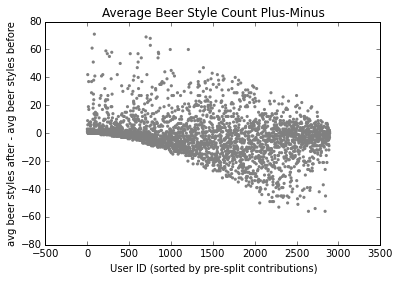

In [9]:
# average number of styles reviewed before/after change
print 'all users style counts'
styles_all = group_time_split(users_split_active, 'beer/style')
# want number of styles
styles_all = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_all)
plot_diff(styles_all)
plt.xlabel('User ID (sorted by pre-split contributions)')
plt.ylabel('avg beer styles after - avg beer styles before')
plt.title('Average Beer Style Count Plus-Minus')
print

print 'top users style counts'
styles_top = group_time_split(users_top_active, 'beer/style')
# want number of styles
styles_top = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_top)
plot_diff(styles_top, lambda x: x, False)
print

print 'low users style counts'
styles_low = group_time_split(users_low_active, 'beer/style')
# want number of styles
styles_low = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_low)
plot_diff(styles_low, lambda x: x, False)
print

print 'sample users style counts'
styles_samp = group_time_split(users_sampled_active, 'beer/style')
# want number of styles
styles_samp = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_samp)
plot_diff(styles_samp, lambda x: x, False)
print

#### Average Overall Rating
Based on the results below, we notice that, across the board, the average overall rating very slightly increased after the profile-page change. However, the increase is very small (smaller than 1%), and seems to reflect that the profile page change didn't markedly impact ratings. 

We note that the standard deviation for high-usage users is significantly smaller for this variable (perhaps due to longtime users have an anchoring affect to what ratings "should" be or having less reviews in the second period).

all users rating avg
Mean p/m:  0.00775300357659
Median p/m:  0.0077741775514
Std Dev p/m:  0.110918460137

top users rating avg
Mean p/m:  0.0104670682491
Median p/m:  0.00786606563649
Std Dev p/m:  0.0280123472408

low users rating avg
Mean p/m:  0.00761000234929
Median p/m:  0.00759119322271
Std Dev p/m:  0.113619447433

sampled users rating avg
Mean p/m:  0.00248713680956
Median p/m:  0.00286119452786
Std Dev p/m:  0.130711459663



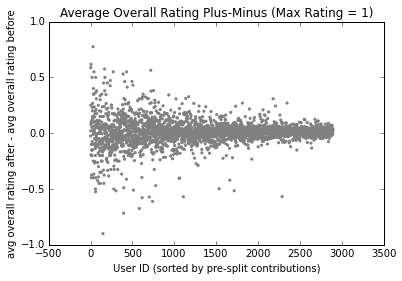

In [10]:
# average overall ratings before/after change
print 'all users rating avg'
rates_all = group_time_split(users_split_active, 'review/overall', lambda x: float(x))
rates_all = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_all)
avg_rates = avg_from_user_array_tuple(rates_all)
plot_diff(avg_rates)
plt.xlabel('User ID (sorted by pre-split contributions)')
plt.ylabel('avg overall rating after - avg overall rating before')
plt.title('Average Overall Rating Plus-Minus (Max Rating = 1)')
print

print 'top users rating avg'
rates_top = group_time_split(users_top_active, 'review/overall', lambda x: float(x))
rates_top = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_top)
avg_rates = avg_from_user_array_tuple(rates_top)
plot_diff(avg_rates, lambda x: x, False)
print

print 'low users rating avg'
rates_low = group_time_split(users_low_active, 'review/overall', lambda x: float(x))
rates_low = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_low)
avg_rates = avg_from_user_array_tuple(rates_low)
plot_diff(avg_rates, lambda x: x, False)
print

print 'sampled users rating avg'
rates_samp = group_time_split(users_sampled_active, 'review/overall', lambda x: float(x))
rates_samp = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_samp)
avg_rates = avg_from_user_array_tuple(rates_samp)
styles_plot = plot_diff(avg_rates, lambda x: x, False)
print

#### Average Review Length
Based on the results below, we notice that, across the board, the average review length very slightly increased after the profile-page change. However, the increase is very small (smaller than 1 word), and seems to reflect that the profile page change didn't markedly impact review length. 

We note that the standard deviation for high-usage users is significantly smaller for this variable (perhaps due to longtime users have an anchoring affect to what reviews "should" be or having less reviews in the second period).

all users review length avg
Mean p/m:  0.915084570245
Median p/m:  0.0
Std Dev p/m:  18.9924417756

top users review length avg
Mean p/m:  0.68275862069
Median p/m:  -1.0
Std Dev p/m:  8.49560003627

low users review length avg
Mean p/m:  0.927325581395
Median p/m:  0.0
Std Dev p/m:  19.3884655488

sampled users review length avg
Mean p/m:  2.71724137931
Median p/m:  1.0
Std Dev p/m:  19.908308246



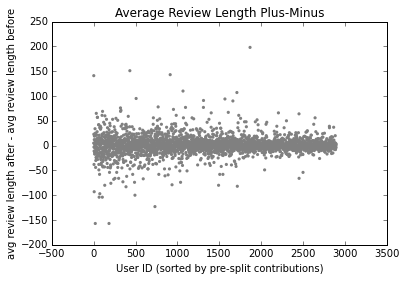

In [11]:
# average review lengths before/after change
print 'all users review length avg'
reviews_all = group_time_split(users_split_active, 'review/text', lambda x: float(x))
reviews_all = map(lambda x: [[(len(review.split()),  x[0][review]) for review in x[0].keys()], [(len(review.split()),  x[1][review]) for review in x[1].keys()]], reviews_all)
avg_review_len = avg_from_user_array_tuple(reviews_all)
styles_plot = plot_diff(avg_review_len)
plt.xlabel('User ID (sorted by pre-split contributions)')
plt.ylabel('avg review length after - avg review length before')
plt.title('Average Review Length Plus-Minus')
print

print 'top users review length avg'
reviews_top = group_time_split(users_top_active, 'review/text', lambda x: float(x))
reviews_top = map(lambda x: [[(len(review.split()),  x[0][review]) for review in x[0].keys()], [(len(review.split()),  x[1][review]) for review in x[1].keys()]], reviews_top)
avg_review_len = avg_from_user_array_tuple(reviews_top)
styles_plot = plot_diff(avg_review_len, lambda x: x, False)
print

print 'low users review length avg'
reviews_low = group_time_split(users_low_active, 'review/text', lambda x: float(x))
reviews_low = map(lambda x: [[(len(review.split()),  x[0][review]) for review in x[0].keys()], [(len(review.split()),  x[1][review]) for review in x[1].keys()]], reviews_low)
avg_review_len = avg_from_user_array_tuple(reviews_low)
styles_plot = plot_diff(avg_review_len, lambda x: x, False)
print

print 'sampled users review length avg'
reviews_samp = group_time_split(users_sampled_active, 'review/text', lambda x: float(x))
reviews_samp = map(lambda x: [[(len(review.split()),  x[0][review]) for review in x[0].keys()], [(len(review.split()),  x[1][review]) for review in x[1].keys()]], reviews_samp)
avg_review_len = avg_from_user_array_tuple(reviews_samp)
styles_plot = plot_diff(avg_review_len, lambda x: x, False)
print


###Explore Potential Linear Correlation
Based on the earlier high-level analysis performed, it seemed apparent that some of the features visibly exhibited patterns suggesting some form of correlation. In order to further explore this idea, we performed a correlation analysis (focusing on linear correlation) on each "pre-split" feature -- total number of reviews, number of styles reviewed, average overall rating, number of distinct ratings, average review length, and number of distinct review lengths. 

For each of these features, we calculated the pearson correlation coefficient against both the number of post-split reviews and the review count plus-minus for each user.

####Setting up Feature Vectors

In [12]:
# build feature vectors
x, y_after, y_diff = [], [], []
for user in user_vals_split:
    pre_char = user[0]
    style_map = groupby_key_count(pre_char, 'beer/style')
    rating_map = groupby_key_count(pre_char, 'review/overall')
    review_map = groupby_key_count(pre_char, 'review/text', lambda x : len(x.split()))
    total_count = len(pre_char)
    style_count = len(style_map.keys())
    avg_rating = avg_from_map(rating_map)
    rating_count = len(rating_map.keys())
    avg_review = avg_from_map(review_map)
    review_count = len(review_map.keys())
    # throw away points that don't have rating / review
    if (avg_rating is not None and avg_review is not None):
        x.append([total_count, style_count, avg_rating, rating_count, avg_review, review_count])
        y_after.append(len(user[1]))
        y_diff.append(len(user[1])-len(user[0]))
data_pool = zip(x,y_diff)

In [13]:
def balance_pool(pool):
    """
    Given a pool of year-key formatted unbalanced outcome data, return a balanced set where positive outcomes have equal number of occurances to negative outcomes
    The larger set is randomly sampled to reduce its size by using reservoir_sample
    """
    newpool = []
    neg = []
    pos = []
    for user in pool:
        if user[-1] < 0:
            neg.append(user)
        else:
            pos.append(user)
    minlen = min(len(pos), len(neg))
    for elem in reservoir_sample(neg, minlen):
        newpool.append(elem)
    for elem in reservoir_sample(pos, minlen):
        newpool.append(elem)
    return newpool

def create_train_test(pool, test, train):
    """
    Split the data pool created in create_data_pool randomly into a 80/20 split between training data and testing data
    Shuffles all the years and randomly splits 80/20 between training and test
    Should only be ran once to randomly split train/test data as it will return different results between runs
    """
    random.shuffle(pool)
    ind = int(len(pool) * 0.8)
    train += pool[:ind]
    test += pool[ind:]

####Pearson Correlation Coefficient
Based on our results for the Correlation Coefficient, only one of our features exibits a value suggesting a good linear fit: the correlation coefficient between number of pre-split reviews and the number of post-split reviews (a correlation coefficient of ~0.84). 

In [14]:
# calculate pearson correlation coefficient for each variable
# use to predict plus-minus and actual number of reviews after 
import scipy.stats
np_x = np.array(x)
np_y_after = np.array(y_after)
np_y_diff = np.array(y_diff)
"""
Index to Pre-Split Feature Mapping
0 - total number of reviews
1 - number of styles reviewed
2 - average overall rating
3 - number of distinct ratings
4 - average review length
5 - number of distinct review lengths
"""
print "Pearson Correlation Coefficients Against Post-Split Number of Reviews"
for i in xrange(len(np_x[0])):
    print "pearson for char", i, ":", scipy.stats.pearsonr(np_x[:,i], np_y_after)
print
print "Pearson Correlation Coefficients Against Number of Reviews Plus-Minus"
for i in xrange(len(np_x[0])):
    print "Difference -- pearson for char", i, ":", scipy.stats.pearsonr(np_x[:,i], np_y_diff)

Pearson Correlation Coefficients Against Post-Split Number of Reviews
pearson for char 0 : (0.84293301632392081, 0.0)
pearson for char 1 : (0.61428885821138934, 0.0)
pearson for char 2 : (-0.075770483278830861, 2.3076444277384334e-09)
pearson for char 3 : (0.47896160540494492, 0.0)
pearson for char 4 : (0.045861436823333934, 0.00030280498922019122)
pearson for char 5 : (0.56550412005318129, 0.0)

Pearson Correlation Coefficients Against Number of Reviews Plus-Minus
Difference -- pearson for char 0 : (-0.17293979966994857, 7.6808482863789563e-43)
Difference -- pearson for char 1 : (-0.18083766616488964, 9.6144655880639793e-47)
Difference -- pearson for char 2 : (0.011217430092585943, 0.37709932116821976)
Difference -- pearson for char 3 : (-0.13978351196549313, 1.9509086371141095e-28)
Difference -- pearson for char 4 : (0.017538289430930002, 0.16727379027134875)
Difference -- pearson for char 5 : (-0.16306462574961997, 3.2190764318208399e-38)


In order to visualize this relationship, we plotted these two features and fit a linear line against them. The result of this operation is shown below. 

The linear fit has a R^2 value of ~0.71, which is not great. The few high-contribution users in the top-right corner seem to be driving the positive linear relationship and the high concentration of user points in the lower-left hand corner seem to suggest that a linear model might not be the right fit for this data.

r-squared: 0.710536070009


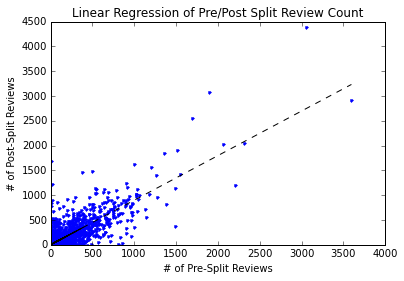

In [15]:
slope, intercept, r_value, p_value, std_err= scipy.stats.linregress(np_x[:,0], np_y_after)
print "r-squared:", r_value**2

fit = np.polyfit(np_x[:,0],np_y_after,1)
fit_fn = np.poly1d(fit)
_ = plt.plot(np_x[:,0], np_y_after, 'b.', x, fit_fn(x), '--k')
plt.ylim(0)
plt.xlabel('# of Pre-Split Reviews')
plt.ylabel('# of Post-Split Reviews')
plt.title('Linear Regression of Pre/Post Split Review Count')

###Explore Binary Classifier
Even though no clear linear correlation is apparent to us based on our analysis so far of the select features, we thought it'd be worthwhile to test different linear classification methods with our selected feature. By doing so, we would be able to evaluate how predictive our set of features really is (based on an actual model evaluation accuracy score). 

Specifically, we were interested in whether our identified list of features could be used to predict whether a user's review contribution would increase or decrease followiing the change in the website. As we were attempting to create a positive/negative classifier, we first created a balanced pool of data to work from -- where there were an equal number of positive and negative samples (where positive/negative is determined by the user's review count plus-minus).  Following this, we split the data pool 80/20 into a training and test set. We chose to perform cross_validation (n=4) to evaluate different models and used a standard mean/standard deviation scaling to normalize our feature values. 

For the purposes of this assignment, we looked at 4 different sklearn classifiers: rbf SVM, linear SVM, dual-l2 logistic regression, non-dual-l2 logistic regression. From a cross-validation score, the model which performed best was the rbf SVM algorithm. 

Overall, this resulted in a 62% accuracy (consistent with the output from the other classifiers) -- a score that is not very good and not that much better than random. This leads us to believe that the features we selected are not strongly predictive of future review contributions to the RateBeer website. 

In [16]:
bal_data_pool = balance_pool(data_pool)
test, train = [], []
create_train_test(bal_data_pool, test, train)

train = [[user[0] for user in train], [1 if user[1] > 0 else -1 for user in train]]
test = [[user[0] for user in test], [1 if user[1] > 0 else -1 for user in test]]

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm, neighbors, qda, metrics, cross_validation
from sklearn.pipeline import Pipeline

clf = Pipeline([('Scaler', StandardScaler()),
#                 ('Log-Reg', linear_model.LogisticRegression(penalty='l2', dual=True))])
#                     ('Log-Reg', linear_model.LogisticRegression(penalty='l2', dual=False))])
#                     ('SVC-linear', svm.SVC(kernel='linear'))])
                    ('SVC-rbf', svm.SVC(kernel='rbf'))])

cv = cross_validation.KFold(len(train[0]), n_folds=4, shuffle=True)
scores = cross_validation.cross_val_score(clf, train[0], train[1], cv=cv)
print "Cross Validation Scores:", scores
print "Average Cross Validation Score:", np.average(scores)
print
# peforms test on selected model
clf = clf.fit(train[0], train[1])
predicted = clf.predict(test[0])
print "Model Accuracy:", metrics.accuracy_score(test[1], predicted)
print "Confusion Matrix"
print metrics.confusion_matrix(test[1], predicted)


Cross Validation Scores: [ 0.61764706  0.64705882  0.6092437   0.63865546]
Average Cross Validation Score: 0.628151260504

Model Accuracy: 0.665966386555
Confusion Matrix
[[176  73]
 [ 86 141]]
